In [1]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and training
import tensorflow as tf                          # For deep learning framework
from keras.models import Sequential              # For creating sequential models
from keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU  # Layers for building neural networks
from keras.regularizers import l2               # For L2 regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # For training optimization

# Libraries for evaluation and preprocessing
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.preprocessing import StandardScaler # For standardizing features
from sklearn.model_selection import KFold, train_test_split # For cross-validation and splitting data

# Set seed for reproducibility
np.random.seed(50)                              # Seed for NumPy
tf.random.set_seed(50)                          # Seed for TensorFlow

In [2]:
# Load dataset and display basic information

# Define the path to the dataset
dataset_path = '../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    # Exit the notebook if the dataset is not found
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()

# Display the first five rows for a quick preview
print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726984 entries, 0 to 726983
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         726984 non-null  object 
 1   device_id    726984 non-null  object 
 2   co2          726984 non-null  float64
 3   humidity     726984 non-null  float64
 4   pm25         726984 non-null  float64
 5   pressure     726984 non-null  float64
 6   temperature  726984 non-null  float64
 7   rssi         726984 non-null  float64
 8   snr          726984 non-null  float64
 9   SF           726984 non-null  int64  
 10  frequency    726984 non-null  float64
 11  f_count      726984 non-null  float64
 12  p_count      726984 non-null  float64
 13  toa          726984 non-null  float64
 14  distance     726984 non-null  int64  
 15  c_walls      726984 non-null  int64  
 16  w_walls      726984 non-null  int64  
 17  exp_pl       726

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:00:52.542462+00:00,ED3,633.0,54.22,0.58,300.41,23.85,-71.0,12.2,10,867.9,94.0,104.0,0.452608,18,1,2,88.4,-83.454107,-71.254107
1,2024-09-26 11:01:52.383162+00:00,ED3,645.0,54.18,0.32,300.48,23.87,-74.0,12.5,9,867.7,95.0,105.0,0.246784,18,1,2,91.4,-86.737602,-74.237602
2,2024-09-26 11:02:52.425491+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
3,2024-09-26 11:02:52.426016+00:00,ED3,648.0,54.23,0.58,300.50,23.88,-76.0,12.2,9,867.1,96.0,106.0,0.246784,18,1,2,93.4,-88.454107,-76.254107
4,2024-09-26 11:03:52.481201+00:00,ED3,645.0,54.25,0.33,300.50,23.90,-76.0,13.2,9,868.3,97.0,107.0,0.246784,18,1,2,93.4,-89.403045,-76.203045


In [3]:
# Extract necessary columns and perform train-test split with normalization

# Define feature columns and target
feature_columns = [
    'distance', 
    'frequency', 
    'c_walls', 
    'w_walls', 
    'co2', 
    'humidity', 
    'pm25', 
    'pressure', 
    'temperature', 
    'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist in the dataframe
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, 
    PL_all, 
    test_size=0.2, 
    random_state=50
)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_all_scaled = scaler.fit_transform(X_train_all)

# Transform the test data
X_test_all_scaled = scaler.transform(X_test_all)

print("Feature scaling completed.")

Feature scaling completed.


In [4]:
def create_ann_model(input_dim):
    """Creates an enhanced ANN model for regression with regularization and improved 
    architecture."""
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Explicit Input layer
    
    # First Hidden Layer
    model.add(Dense(128, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))  # Updated parameter
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Second Hidden Layer
    model.add(Dense(64, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))  # Updated parameter
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Third Hidden Layer
    model.add(Dense(32, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))  # Updated parameter
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Fourth Hidden Layer
    model.add(Dense(16, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU(negative_slope=0.1))  # Updated parameter
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Instantiate the model
input_dim = X_train_all_scaled.shape[1]
model = create_ann_model(input_dim)
model.summary()

# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_ann_model.keras',  # Changed extension to .keras
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train the model with Callbacks
history = model.fit(
    X_train_all_scaled,
    PL_train_all,
    validation_split=0.2,
    epochs=50,  # Increased epochs to allow more training
    batch_size=128,  # Reduced batch size for more frequent updates
    verbose=1,
    callbacks=[early_stop, model_checkpoint, reduce_lr]
)

print("Model training completed.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,249 (51.75 KB)

 Trainable params: 12,769 (49.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
3629/3635 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4624.8887 - mae: 60.6309 
Epoch 1: val_loss improved from inf to 31.70666, saving model to best_ann_model.keras
3635/3635 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 4620.1406 - mae: 60.5821 - val_loss: 31.7067 - val_mae: 4.0001 - learning_rate: 0.0010
Epoch 2/50
3633/3635 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 248.7849 - mae: 12.3227 
Epoch 2: val_loss did not improve from 31.70666
3635/3635 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 248.7822 - mae: 12.3226 - val_loss: 31.7783 - val_mae: 4.0846 - learning_rate: 0.0010
Epoch 3/50
3633/3635 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 234.0418 - mae: 11.9391 
Epoch 3: val_loss improved from 31.70666 to 26.24425, saving model to best_ann_model.keras
3635/3635 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 234.0403 - mae: 11.9390 - val_loss: 26.2442 - val_mae: 3.6925 - learning_rate: 0.0010
Epoch 4/50
3630/3635 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 222.1380 - mae: 11.5873 
Epoch 4: va

In [5]:
# Evaluate the trained model on training and test data and display metrics in a table

# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train_all_scaled, PL_train_all, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)

# Predict path loss for the test set
PL_pred = model.predict(X_test_all_scaled).flatten()

# Calculate additional metrics
rmse_test = np.sqrt(mean_squared_error(PL_test_all, PL_pred))
r2_test = r2_score(PL_test_all, PL_pred)
mape_test = mean_absolute_percentage_error(PL_test_all, PL_pred)
median_ae_test = median_absolute_error(PL_test_all, PL_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Training MAE', 
               'Test Loss (MSE)', 'Test MAE', 
               'Test RMSE', 'R² Score', 
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_loss, train_mae, 
              test_loss, test_mae, 
              rmse_test, r2_test, 
              mape_test * 100, median_ae_test]
})

# Display the results table
print("\nModel Evaluation Metrics:")
display(results)

4544/4544 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),17.359594
1,Training MAE,2.967114
2,Test Loss (MSE),17.213593
3,Test MAE,2.970029
4,Test RMSE,4.077740
5,R² Score,0.953149
6,Test MAPE (%),3.396786
7,Test Median AE,2.358549


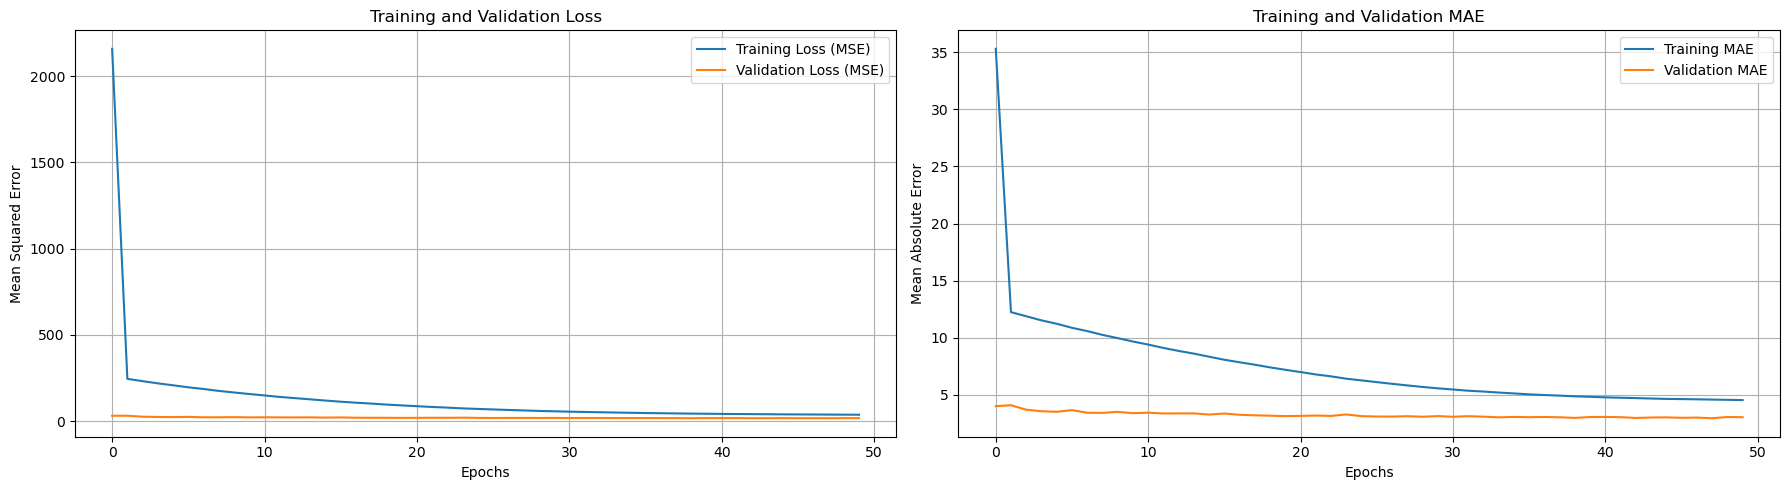

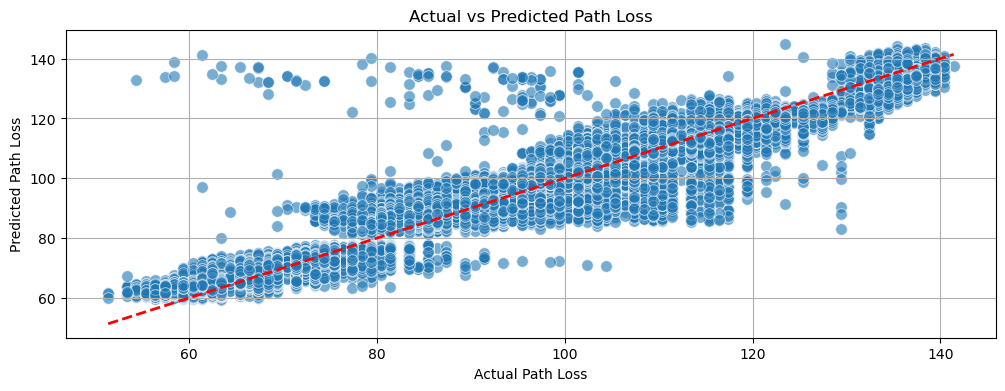

In [6]:
# Visualize training history and model predictions

# Plot training and validation loss
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(12, 4))
sns.scatterplot(x=PL_test_all, y=PL_pred, alpha=0.6, edgecolor='w', s=70)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()


In [7]:
# Perform K-Fold Cross-Validation to assess model robustness and display results in a table

# Define K-Fold Cross Validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cv_results_list = []

for train_index, val_index in kf.split(X_train_all_scaled):
    print(f"Training fold {fold}...")
    
    # Split data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_all_scaled[train_index], X_train_all_scaled[val_index]
    PL_train_fold, PL_val_fold = PL_train_all[train_index], PL_train_all[val_index]
    
    # Create a new instance of the model for each fold
    model = create_ann_model(input_dim)
    
    # Define Callbacks
    early_stop_cv = EarlyStopping(
        monitor='val_loss',
        patience=30,  # Patience can be adjusted as needed
        restore_best_weights=True
    )
    
    model_checkpoint_cv = ModelCheckpoint(
        f'best_ann_model_fold_{fold}.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=0
    )
    
    reduce_lr_cv = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=0
    )
    
    # Train the model on the current fold
    history_cv = model.fit(
        X_train_fold, 
        PL_train_fold, 
        validation_data=(X_val_fold, PL_val_fold),
        epochs=50, 
        batch_size=256, 
        callbacks=[early_stop_cv, model_checkpoint_cv, reduce_lr_cv],
        verbose=0  # Set to 1 for detailed output
    )
    
    # Load the best model from the current fold
    best_model = tf.keras.models.load_model(f'best_ann_model_fold_{fold}.keras')
    
    # Predict path loss for the test set
    PL_pred_cv = best_model.predict(X_test_all_scaled).flatten()
    
    # Calculate metrics
    test_loss, test_mae = best_model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
    rmse_cv = np.sqrt(mean_squared_error(PL_test_all, PL_pred_cv))
    r2_cv = r2_score(PL_test_all, PL_pred_cv)
    mape_cv = mean_absolute_percentage_error(PL_test_all, PL_pred_cv)
    median_ae_cv = median_absolute_error(PL_test_all, PL_pred_cv)
    
    # Append metrics to the results list
    cv_results_list.append({
        'Fold': fold,
        'Test Loss (MSE)': round(test_loss, 4),
        'Test MAE': round(test_mae, 4),
        'Test RMSE': round(rmse_cv, 4),
        'R² Score': round(r2_cv, 4),
        'Test MAPE (%)': round(mape_cv * 100, 2),
        'Test Median AE': round(median_ae_cv, 4)
    })
    
    print(f"Fold {fold} - Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}, RMSE: {rmse_cv:.4f}, R²: {r2_cv:.4f}, MAPE: {mape_cv*100:.2f}%, Median AE: {median_ae_cv:.4f}\n")
    fold += 1

# Create a DataFrame from the results
cv_results_df = pd.DataFrame(cv_results_list)

# Calculate average and standard deviation for each metric
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Display Cross-Validation Results
print("K-Fold Cross-Validation Results:")
display(cv_results_df)

print("Cross-Validation Summary:")
display(cv_summary)

Training fold 1...
4544/4544 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Fold 1 - Test Loss (MSE): 18.4193, Test MAE: 3.0585, RMSE: 4.2352, R²: 0.9495, MAPE: 3.40%, Median AE: 2.3500

Training fold 2...
4544/4544 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Fold 2 - Test Loss (MSE): 17.2478, Test MAE: 2.9772, RMSE: 4.0937, R²: 0.9528, MAPE: 3.35%, Median AE: 2.3105

Training fold 3...
4544/4544 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Fold 3 - Test Loss (MSE): 17.0415, Test MAE: 2.9211, RMSE: 4.0691, R²: 0.9533, MAPE: 3.29%, Median AE: 2.2585

Training fold 4...
4544/4544 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Fold 4 - Test Loss (MSE): 18.0184, Test MAE: 3.0187, RMSE: 4.1871, R²: 0.9506, MAPE: 3.37%, Median AE: 2.3292

Training fold 5...
4544/4544 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Fold 5 - Test Loss (MSE): 18.1488, Test MAE: 3.0570, RMSE: 4.2035, R²: 0.9502, MAPE: 3.48%, Median AE: 2.4130

K-Fold Cross-Validation Results:


,Fold,Test Loss (MSE),Test MAE,Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,1,18.4193,3.0585,4.2352,0.9495,3.40,2.3500
1,2,17.2478,2.9772,4.0937,0.9528,3.35,2.3105
2,3,17.0415,2.9211,4.0691,0.9533,3.29,2.2585
3,4,18.0184,3.0187,4.1871,0.9506,3.37,2.3292
4,5,18.1488,3.0570,4.2035,0.9502,3.48,2.4130


Cross-Validation Summary:


,Metric,Fold,Test Loss (MSE),Test MAE,Test RMSE,R² Score,Test MAPE (%),Test Median AE
0,mean,3.0000,17.7752,3.0065,4.1577,0.9513,3.3780,2.3322
1,std,1.5811,0.5979,0.0582,0.0723,0.0017,0.0698,0.0565
